In [1]:
import re
import pandas as pd
from sf_utils import CONN_PARAM
from snowflake.connector.pandas_tools import write_pandas

In [2]:
from snowflake.snowpark.session import Session
from snowflake.snowpark.types import IntegerType, FloatType
from snowflake.snowpark.functions import avg, sum, col, udf, call_udf, call_builtin, year
from datetime import date
from sklearn.linear_model import LinearRegression

/Users/davidsm/opt/anaconda3/envs/snowpark_frosty/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
session = Session.builder.configs(CONN_PARAM).create()

# Exploration

In [4]:
df_pce_expl = session.sql('''SELECT "Date", "Value" FROM "ECONOMY_DATA_ATLAS"."ECONOMY"."BEANIPA" 
WHERE "Table Name" = 'Price Indexes For Personal Consumption Expenditures By Major Type Of Product' 
AND "Indicator Name" = 'Personal consumption expenditures (PCE)' AND "Frequency" = 'A' 
ORDER BY "Date"
''').to_pandas()

In [5]:
df_pce_expl.head()

,Date,Value
0,1929-01-01,9.296
1,1930-01-01,8.902
2,1931-01-01,7.949
3,1932-01-01,7.010
4,1933-01-01,6.761


<AxesSubplot: xlabel='Date'>

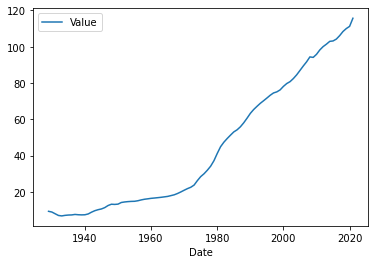

In [6]:
df_pce_expl.plot(x="Date",y="Value")

### Set arbitrary cut off based on graph shape

In [7]:
arbitrary_cut_off = '1980-01-01'

# Train and predict

In [8]:
df_pce = (session.table("ECONOMY_DATA_ATLAS.ECONOMY.BEANIPA")
          .filter(col('"Table Name"') == 'Price Indexes For Personal Consumption Expenditures By Major Type Of Product')
          .filter(col('"Indicator Name"') == 'Personal consumption expenditures (PCE)')
          .filter(col('"Frequency"') == 'A')
          .filter(col('"Date"') >= arbitrary_cut_off))
pd_df_pce_year = df_pce.select(year(col('"Date"')).alias('YEAR'), col('"Value"').alias('PCE') ).to_pandas()
pd_df_pce_year.head()

,YEAR,PCE
0,1980,41.182
1,1981,44.871
2,1982,47.363
3,1983,49.378
4,1984,51.243


In [9]:
# train model
x = pd_df_pce_year["YEAR"].to_numpy().reshape(-1,1)
y = pd_df_pce_year["PCE"].to_numpy()

model = LinearRegression().fit(x, y)

In [10]:
@udf(name="predict_pce_udf_sp",
     is_permanent=True,
     stage_location="@DVD_FROSTY_FRIDAYS",
     return_type=FloatType(),
     input_types=[IntegerType()],
     packages= ["pandas","scikit-learn"],
     replace=True,
     session=session)
def pce_forecast(target_year: int) -> float:
    return model.predict([[target_year]])[0].round(2).astype(float)

In [11]:
session.sql("select predict_pce_udf_sp(2021)").show()

------------------------------
|"PREDICT_PCE_UDF_SP(2021)"  |
------------------------------
|114.31                      |
------------------------------

